In [1]:
import pandas as pd
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

figure_path = src.figures_path / "DI"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
ins = pd.read_csv(src.processed_data_path / "di_score_r25kb_w1Mb.txt", index_col=0, sep="\t")
ins['chrom'] = 'chr' + ins.chrom.astype(str)
ins.columns = src.coords + ['bad', 'di_ratio', 'di_index']
# ins.di_ratio = ins.di_ratio.fillna(0)
# ins.di_index = ins.di_index.fillna(0)
ins.head()

,chr,start,end,bad,di_ratio,di_index
0,chr1,0,25000,True,NaN,NaN
1,chr1,25000,50000,True,NaN,NaN
2,chr1,50000,75000,True,NaN,NaN
3,chr1,75000,100000,True,NaN,NaN
4,chr1,100000,125000,True,NaN,NaN


## Enrichment of CTCF sites at DI inversion points

In [3]:
ins_noY = ins[~ins.chr.isin(['chrY', 'chrMT'])]

In [4]:
ins_with_neigh = []
for chrom in src.progress(ins_noY.chr.unique()):
    ins_chrom = ins_noY[ins_noY.chr == chrom].sort_values(src.coords)
    ins_chrom['di_ratio_before'] = ins_chrom.shift(1)['di_ratio']
    ins_chrom['di_ratio_after'] = ins_chrom.shift(-1)['di_ratio']  
    
    ins_with_neigh.append(ins_chrom)
    
ins_with_neigh = pd.concat(ins_with_neigh, axis=0, ignore_index=True)
ins_with_neigh.head()

,chr,start,end,bad,di_ratio,di_index,di_ratio_before,di_ratio_after
0,chr1,0,25000,True,NaN,NaN,NaN,NaN
1,chr1,25000,50000,True,NaN,NaN,NaN,NaN
2,chr1,50000,75000,True,NaN,NaN,NaN,NaN
3,chr1,75000,100000,True,NaN,NaN,NaN,NaN
4,chr1,100000,125000,True,NaN,NaN,NaN,NaN


In [20]:
ins_with_neigh['DI_point_type'] = 'middle'
ins_with_neigh.loc[(ins_with_neigh.di_ratio_before > 0) & (ins_with_neigh.di_ratio < 0), 'DI_point_type'] = 'negative_inversion'
ins_with_neigh.loc[(ins_with_neigh.di_ratio_before < 0) & (ins_with_neigh.di_ratio > 0), 'DI_point_type'] = 'positive_inversion'

ins_with_neigh['point_of_interest'] = 'middle'
ins_with_neigh.loc[ins_with_neigh.DI_point_type == 'negative_inversion', 'point_of_interest'] = 'tad_center'
ins_with_neigh.loc[ins_with_neigh.DI_point_type == 'positive_inversion', 'point_of_interest'] = 'boundary'

ins_with_neigh.to_csv(src.interim_data_path / "GM12878_25kb_DI_poi.tsv", sep='\t', index=False, header=True)
ins_with_neigh.head()

,chr,start,end,bad,di_ratio,di_index,di_ratio_before,di_ratio_after,point_type,DI_point_type,point_of_interest
0,chr1,0,25000,True,NaN,NaN,NaN,NaN,middle,middle,middle
1,chr1,25000,50000,True,NaN,NaN,NaN,NaN,middle,middle,middle
2,chr1,50000,75000,True,NaN,NaN,NaN,NaN,middle,middle,middle
3,chr1,75000,100000,True,NaN,NaN,NaN,NaN,middle,middle,middle
4,chr1,100000,125000,True,NaN,NaN,NaN,NaN,middle,middle,middle


In [6]:
di_centers = ins_with_neigh[ins_with_neigh.point_type == 'tad_center'].copy()
di_centers['di_center_uid'] = np.arange(di_centers.shape[0], dtype=int)
di_centers.head()

,chr,start,end,bad,di_ratio,di_index,di_ratio_before,di_ratio_after,point_type,di_center_uid
45,chr1,1125000,1150000,False,-0.098854,-0.003667,0.091927,-0.184930,tad_center,0
55,chr1,1375000,1400000,False,-0.090922,-0.003008,0.004794,-0.121218,tad_center,1
64,chr1,1600000,1625000,False,-0.136868,-0.006450,0.067812,-0.226981,tad_center,2
69,chr1,1725000,1750000,False,-0.025038,-0.000189,0.051345,-0.180918,tad_center,3
89,chr1,2225000,2250000,False,-0.152505,-0.007702,0.013221,-0.094328,tad_center,4


In [7]:
extended = 250*1000
window_size = 5*1000

centered_di = di_centers.copy()
centers = centered_di.start
centered_di['start'] = centers
centered_di['end'] = centers

centered_di = BedTool.from_dataframe(centered_di).slop(b=extended, genome='hg19').to_dataframe(names=centered_di.columns)
centered_di.head()

,chr,start,end,bad,di_ratio,di_index,di_ratio_before,di_ratio_after,point_type,di_center_uid
0,chr1,875000,1375000,False,-0.098854,-0.003667,0.091927,-0.18492981628849853,tad_center,0
1,chr1,1125000,1625000,False,-0.090922,-0.003008,0.004794,-0.12121755358181276,tad_center,1
2,chr1,1350000,1850000,False,-0.136868,-0.006450,0.067812,-0.2269807370096416,tad_center,2
3,chr1,1475000,1975000,False,-0.025038,-0.000189,0.051345,-0.1809184747464646,tad_center,3
4,chr1,1975000,2475000,False,-0.152505,-0.007702,0.013221,-0.0943282062129463,tad_center,4


In [8]:
centered_di = centered_di[centered_di.end - centered_di.start == extended*2]
windows = src.windowing_by_size(centered_di[src.coords + ['di_center_uid']], window_size=window_size)

In [9]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t")
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs[['orientation','context']], prefix="", prefix_sep="")), axis=1)
ctcfs = ctcfs.rename(columns={'>': 'forward', '<': 'reverse'})
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs.orientation + ctcfs.context)), axis=1)
ctcfs = ctcfs.merge(pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t"), on=src.coords + ['orientation'])
ctcfs.head()

,chr,start,end,orientation,context,reverse,forward,C,CD,D,...,<T,>C,>CD,>D,>S,>T,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,T,0,1,0,0,0,...,0,0,0,0,0,1,0,9.790746,12.639115,1.502743e+09
1,chr1,521337,521697,>,S,0,1,0,0,0,...,0,0,0,0,1,0,1,10.259412,13.836791,1.680162e+09
2,chr1,714087,714447,>,S,0,1,0,0,0,...,0,0,0,0,1,0,2,9.893988,9.326291,1.342770e+09
3,chr1,805232,805362,>,S,0,1,0,0,0,...,0,0,0,0,1,0,3,14.365820,46.641218,3.446545e+09
4,chr1,839966,840326,>,S,0,1,0,0,0,...,0,0,0,0,1,0,4,16.393501,60.468042,3.756117e+09


In [10]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum'}


windows_with_ctcf = src.coverage_by_window(windows, ctcfs, aggregations)
windows_with_ctcf = windows_with_ctcf.merge(di_centers.drop(src.coords, axis=1), on='di_center_uid')

In [11]:
aggregations_by_bound_tot = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcf.pivot_table(index='di_center_uid', columns='w_num', values=c).sort_index(axis=1)
    cagg = cagg.sort_index(axis=1)
    aggregations_by_bound_tot[c] = cagg

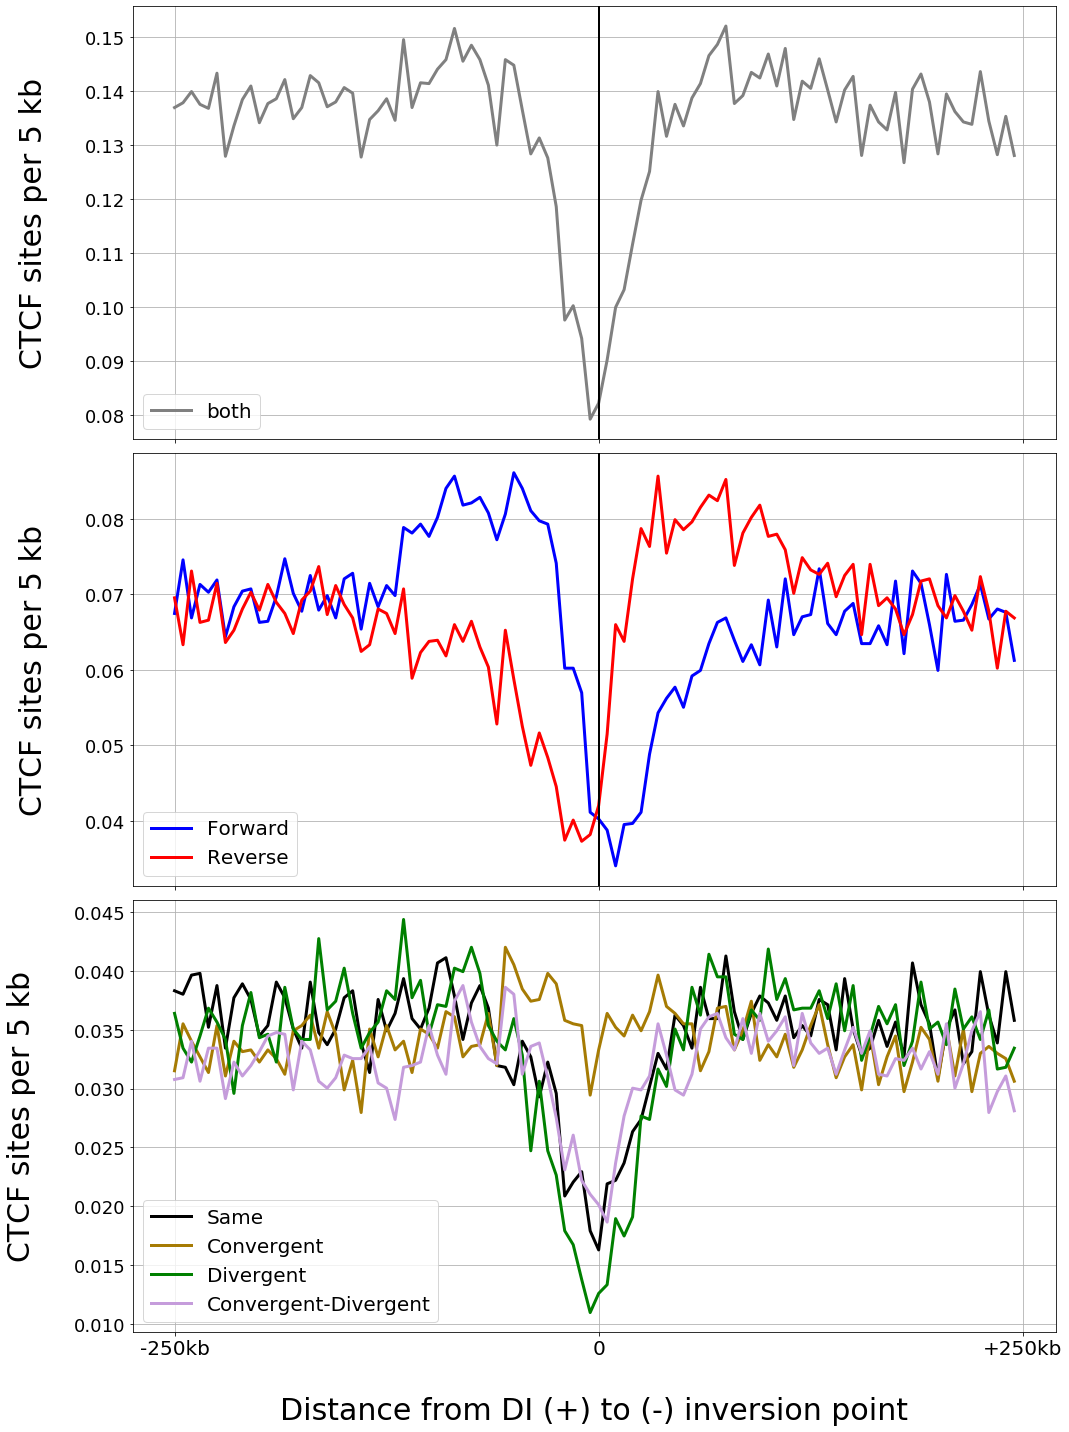

In [13]:
linewidth=3
legendfont = 20
labelfont = 30
tickfont = 20

fig, axes = plt.subplots(3,1,sharex=True,figsize=(15, 20), tight_layout=True)
axes[0].plot(aggregations_by_bound_tot['ctcf_id'].mean(0), linewidth=linewidth, label='both', color=src.ctcf_colors['all'])
axes[0].set_ylabel("CTCF sites per 5 kb\n", fontsize=labelfont)
axes[0].axvline(extended/window_size, color='black')
axes[0].grid()
axes[0].legend(loc='lower left', fontsize=legendfont)

axes[1].plot(aggregations_by_bound_tot['forward'].mean(0), linewidth=linewidth, label='Forward', color=src.ctcf_colors['forward'])
axes[1].plot(aggregations_by_bound_tot['reverse'].mean(0), linewidth=linewidth, label='Reverse', color=src.ctcf_colors['reverse'])
axes[1].set_ylabel("CTCF sites per 5 kb\n", fontsize=labelfont)
axes[1].axvline(extended/window_size, color='black')
axes[1].grid()
axes[1].legend(loc='lower left', fontsize=legendfont)

axes[2].plot(aggregations_by_bound_tot['S'].mean(0), linewidth=linewidth, label='Same', color=src.ctcf_colors['S'])
axes[2].plot(aggregations_by_bound_tot['C'].mean(0), linewidth=linewidth, label='Convergent', color=src.ctcf_colors['C'])
axes[2].plot(aggregations_by_bound_tot['D'].mean(0), linewidth=linewidth, label='Divergent', color=src.ctcf_colors['D'])
axes[2].plot(aggregations_by_bound_tot['CD'].mean(0), linewidth=linewidth, label='Convergent-Divergent', color=src.ctcf_colors['CD'])
axes[2].set_ylabel("CTCF sites per 5 kb\n", fontsize=labelfont)
# axes[2].axvline(extension/resolution, color='black')
axes[2].grid()
axes[2].legend(loc='lower left', fontsize=legendfont)

axes[2].set_xticks([0, extended/window_size, extended*2/window_size])
axes[2].set_xticklabels(['-250kb', '0', '+250kb'], fontsize=tickfont)
axes[2].set_xlabel("\nDistance from DI (+) to (-) inversion point", fontsize=labelfont)

# plt.xticks([0, extended/window_size ,extended*2/window_size], labels=['-500kb', 'Boundary center', '+500kb'])
# plt.xlabel("\nPosition", fontsize=20)
# fig.savefig(figure_path / "avg_ctcf_sites_on_bounds_by_window.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Enrichment of CTCF sites at DI triangles

In [14]:
ins_with_neigh_points = ins_with_neigh[ins_with_neigh.point_type != 'middle'].sort_values(src.coords)
ins_with_neigh_points['point_after'] = ins_with_neigh_points.shift(-1).point_type
ins_with_neigh_points['chr_after'] = ins_with_neigh_points.shift(-1).chr
ins_with_neigh_points['start_after'] = ins_with_neigh_points.shift(-1).start
ins_with_neigh_points['end_after'] = ins_with_neigh_points.shift(-1).end
ins_with_neigh_points['di_ratio_after'] = ins_with_neigh_points.shift(-1).di_ratio
ins_with_neigh_points[ins_with_neigh_points.chr == ins_with_neigh_points.chr_after]
ins_with_neigh_points.head()

,chr,start,end,bad,di_ratio,di_index,di_ratio_before,di_ratio_after,point_type,point_after,chr_after,start_after,end_after
45,chr1,1125000,1150000,False,-0.098854,-0.003667,0.091927,0.003689,tad_center,boundary,chr1,1250000.0,1275000.0
50,chr1,1250000,1275000,False,0.003689,0.000006,-0.158575,-0.090922,boundary,tad_center,chr1,1375000.0,1400000.0
55,chr1,1375000,1400000,False,-0.090922,-0.003008,0.004794,0.067812,tad_center,boundary,chr1,1575000.0,1600000.0
63,chr1,1575000,1600000,False,0.067812,0.001816,-0.107206,-0.136868,boundary,tad_center,chr1,1600000.0,1625000.0
64,chr1,1600000,1625000,False,-0.136868,-0.006450,0.067812,0.051345,tad_center,boundary,chr1,1700000.0,1725000.0


In [15]:
pos_triangles = ins_with_neigh_points[(ins_with_neigh_points.point_type == 'boundary') & (ins_with_neigh_points.point_after == 'tad_center')]
pos_triangles = pd.DataFrame({
    'chr': pos_triangles.chr,
    'start': pos_triangles.start.astype(int),
    'end': pos_triangles.end_after.astype(int),
    'triangle_type': 'boundary to center',
    'side': 'positive'
})
print(pos_triangles.shape)
neg_triangles = ins_with_neigh_points[(ins_with_neigh_points.point_type == 'tad_center') & (ins_with_neigh_points.point_after == 'boundary')]
neg_triangles = pd.DataFrame({
    'chr': neg_triangles.chr,
    'start': neg_triangles.start.astype(int),
    'end': neg_triangles.end_after.astype(int),
    'triangle_type': 'center to boundary',
    'side': 'negative'
})
print(neg_triangles.shape)

(6581, 5)
(6581, 5)


In [ ]:
triangles = pos_triangles
triangles['length'] = triangles.end - triangles.start
triangles['triangle_uid'] = np.arange(triangles.shape[0], dtype=int)

centers = triangles.end


extended1 = (500*1000)
extended2 = (100)
window_size = 10*1000

centered_triangles = triangles.copy()
centered_triangles['start'] = centers
centered_triangles['end'] = centers

centered_triangles = BedTool.from_dataframe(centered_triangles).slop(=extended, genome='hg19').to_dataframe(names=centered_triangles.columns)
centered_triangles.head()

In [ ]:
centered_triangles = centered_triangles[centered_triangles.end - centered_triangles.start == extended*2]
windows = src.windowing_by_size(centered_triangles[src.coords + ['triangle_uid']], window_size=window_size)

In [ ]:
# all_biplets = pd.read_csv(src.interim_data_path / "all_biplets.tsv", sep="\t")
# all_biplets.head()

In [ ]:
# biplets = all_biplets[all_biplets.lower_bound_quantile == 0.0].copy()
# biplets.shape

In [ ]:
# def __pattern_to_number(p):
#     if p == '>>':
#         return 0
#     elif p == '<<':
#         return 1
#     elif p == '<>':
#         return 2
#     else:
#         return 3

In [ ]:
# biplets['value'] = biplets.pattern.map(__pattern_to_number)
# biplets.head()

In [ ]:
# biplets.value.value_counts()

In [ ]:
# aggregations = {'value': 'min'}


# windows_with_ctcf = src.coverage_by_window(windows.sort_values(src.coords), biplets.sort_values(src.coords), aggregations)
# windows_with_ctcf = windows_with_ctcf.merge(centered_triangles.drop(src.coords, axis=1), on='triangle_uid')
# windows_with_ctcf.head()

In [ ]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum',
                'MotifScore': 'sum',
                'ChipSeqScore': 'sum'}


windows_with_ctcf = src.coverage_by_window(windows.sort_values(src.coords), ctcfs.sort_values(src.coords), aggregations)
windows_with_ctcf = windows_with_ctcf.merge(centered_triangles.drop(src.coords, axis=1), on='triangle_uid')
windows_with_ctcf.head()

In [ ]:
windows_with_ctcf['value'] = windows_with_ctcf.apply(lambda x: x.forward if x.forward > x.reverse else -x.reverse, axis=1)

In [ ]:
triangles_vs_ctcfs = windows_with_ctcf.pivot_table(index='triangle_uid', columns='w_num', values='value')

In [ ]:
X = triangles_vs_ctcfs.loc[triangles.sort_values('length', ascending=False).triangle_uid.tolist()].dropna().values

In [ ]:
X

In [ ]:
cmap = ListedColormap(['blue', 'red', 'white', 'white'])

In [ ]:
X[X < 0] = -1
X[X > 0] = 1

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(40,70))
pos = ax.imshow(X, aspect='auto', cmap='bwr_r', interpolation= 'nearest')
# fig.colorbar(pos, ax=ax)
plt.show()

In [ ]:
ctcf_scores = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t")
ctcf_scores.head()

In [ ]:
selected_ctcfs = ctcf_scores[ctcf_scores.rank_score_aggregate > ctcf_scores.rank_score_aggregate.quantile(0.25)].copy()
selected_ctcfs.head()

In [ ]:
gaps = pd.read_csv(src.external_data_path / "hg19_gaps.txt", sep="\t")
gaps.columns = ['chr', 'start', 'end', 'gap_type']
gaps = gaps.sort_values(src.coords)
gaps.head()

In [ ]:
blocks = []

for chrom in src.progress(selected_ctcfs.chr.unique()):
    chrom_ctcfs = selected_ctcfs[selected_ctcfs.chr == chrom]
    ids = chrom_ctcfs.ctcf_id.tolist()
    orientations = chrom_ctcfs.orientation.tolist()
    
    previous_orientation = None
    starting_id = None
    for i in range(len(orientations)):
        if starting_id is None:
            starting_id = ids[i]
        if previous_orientation is None:
            previous_orientation = orientations[i]
        else:
            if previous_orientation != orientations[i]:
                blocks.append([starting_id, ids[i-1], previous_orientation])
                starting_id = ids[i]
            previous_orientation = orientations[i]
blocks = pd.DataFrame(data=blocks, columns=['start_id', 'end_id', 'orientation'])
blocks = pd.DataFrame({
    'chr': selected_ctcfs.loc[blocks.start_id].reset_index(drop=True).chr,
    'start': selected_ctcfs.loc[blocks.start_id].reset_index(drop=True).start,
    'end': selected_ctcfs.loc[blocks.end_id].reset_index(drop=True).end,
    'orientation': blocks.orientation.reset_index(drop=True),
    'block_uid': np.arange(blocks.shape[0], dtype=int)
})
blocks.head()

In [ ]:
n_windows = 100
extension = 0.1

tot_windows = n_windows + int(n_windows*extension)*2
block_start_window = int(n_windows*extension)
block_end_window = n_windows + int(n_windows*extension)

In [ ]:
blocks_ext = BedTool.from_dataframe(blocks[src.coords + ['block_uid']].sort_values(src.coords))\
                        .slop(l=extension, r=extension, pct=True, genome="hg19")\
                        .to_dataframe(names=src.coords + ['block_uid'])
blocks_ext.head()

In [ ]:
windows = src.windowing_by_number(blocks_ext, tot_windows)

In [ ]:
aggregations = {'di_index': 'mean', 
                'di_ratio': 'mean'}

windows_with_ctcfs = src.coverage_by_window(windows.sort_values(src.coords), ins.sort_values(src.coords), aggregations)
windows_with_ctcfs.head()

In [ ]:
windows_with_ctcfs = windows_with_ctcfs.merge(blocks.drop(src.coords, axis=1), on='block_uid')

In [ ]:
aggregations_by_block = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcfs.pivot_table(index='block_uid', columns='w_num', values=c).sort_index(axis=1)
    aggregations_by_block[c] = cagg 

In [ ]:
linewidth=3
legendfont = 20
labelfont = 20
tickfont = 20
def plot_di(y):
    fig, axes = plt.subplots(1,1,sharex=True,figsize=(10, 5), tight_layout=True)
    axes.plot(y, linewidth=linewidth, label='both', color='blue')
    axes.fill_between(np.arange(y.shape[0]), y, where=y < 0, facecolor='#4286f4')
    axes.fill_between(np.arange(y.shape[0]), y, where=y >= 0, facecolor='#f45041')
    axes.set_ylabel("Average Directionality Index\non GM12878", fontsize=labelfont)
    axes.axvline(block_start_window, color='black')
    axes.axvline(block_end_window, color='black')
    axes.grid()
    axes.set_xticks([block_start_window, block_end_window])
    axes.set_xticklabels(['Block start','Block end'], fontsize=tickfont)
    return axes

In [ ]:
sns.distplot((blocks.end-blocks.start).map(np.log10))

In [ ]:
selected_blocks = blocks[(blocks.end - blocks.start > 1e4) & (blocks.end - blocks.start < 1e5)]
print(selected_blocks.shape[0])
selected_blocks.head()

In [ ]:
forward_blocks = selected_blocks[selected_blocks.orientation == '>'].block_uid.tolist()
y_forward = aggregations_by_block['di_ratio'].loc[forward_blocks].mean(0)
ax = plot_di(y_forward)
ax.set_title("Forward CTCF blocks", fontsize=labelfont)

reverse_blocks = selected_blocks[selected_blocks.orientation == '<'].block_uid.tolist()
y_reverse = aggregations_by_block['di_ratio'].loc[reverse_blocks].mean(0)
ax = plot_di(y_reverse)
ax.set_title("Reverse CTCF blocks", fontsize=labelfont)

In [ ]:
forward_blocks = blocks[blocks.orientation == '>'].block_uid.tolist()
y_forward = aggregations_by_block['di_ratio'].loc[forward_blocks].mean(0)
ax = plot_di(y_forward)
ax.set_title("Forward CTCF blocks", fontsize=labelfont)

reverse_blocks = blocks[blocks.orientation == '<'].block_uid.tolist()
y_reverse = aggregations_by_block['di_ratio'].loc[reverse_blocks].mean(0)
ax = plot_di(y_reverse)
ax.set_title("Reverse CTCF blocks", fontsize=labelfont)

In [ ]:
y = aggregations_by_block['di_ratio'].mean(0)
ax = plot_di(y)